# 6. Object classifier

In [1]:
from skimage.io import imread, imsave
from pyclesperanto_prototype import imshow, replace_intensities
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from napari_simpleitk_image_processing import label_statistics
import apoc
import os
import pyclesperanto_prototype as cle
import napari
from skimage.segmentation import relabel_sequential
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap

cle.select_device("Intel(R) Iris(TM) Plus Graphics 640")

<Intel(R) Iris(TM) Plus Graphics 640 on Platform: Apple (2 refs)>

### 1.) Data selection

In [2]:
table = pd.read_csv("Correlation_filtered_exclusion.csv")

In [3]:
#image_folder = "/Users/mara/Desktop/Bachelorarbeit/Robert - PoL/20220523_training data/1. images/"
label_folder = '../crystal data/3. excluded small labels/'
annotation_folder = '../crystal data/4. binary masks & table/'

In [4]:
file_list = sorted(os.listdir(label_folder))
file_list

['img01_20220429_ET358_56hpf_1.tif',
 'img02_20220429_ET358_56hpf_2.tif',
 'img03_20220429_ET358_56hpf_3.tif',
 'img05_20220513_ET358_56hpf_1.tif',
 'img06_20220513_ET358_56hpf_2.tif',
 'img08_20220513_ET358_56hpf_4.tif',
 'img10_20220513_ET358_56hpf_6.tif',
 'img12_20220513_ET358_56hpf_8.tif',
 'img13_20220513_ET358_56hpf_9.tif',
 'img14_20220520_hsp-mKate-DN-dynactin_56hpf_1.tif',
 'img15_20220520_hsp-mKate-DN-dynactin_56hpf_2.tif',
 'img17_20220520_hsp-mKate-DN-dynactin_56hpf_4.tif',
 'img18_20220520_hsp-mKate-DN-dynactin_56hpf_5.tif']

In [5]:
#image_list = []
label_list = []
annotation_list = []
all_annotated_classes = []

for i, filename in enumerate(file_list):
    #read image, label, annotation
    #image = imread(image_folder + filename)
    label = imread(label_folder + filename)
    annotation = imread(annotation_folder + filename)
    
    #get all annotated classes
    annotation_stats = regionprops(label, intensity_image=annotation)
    annotated_classes = np.asarray([s.max_intensity for s in annotation_stats])
    all_annotated_classes = np.concatenate((all_annotated_classes, annotated_classes))
    
    #append image, label and annotation to list
    label_list.append(label)
    annotation_list.append(annotation)

### 2.) Training

In [6]:
classifier_filename = 'table_row_classifier_all_measurements_sorted.cl'

classifier = apoc.TableRowClassifier(opencl_filename=classifier_filename, max_depth=2, num_ensembles=10)
classifier.train(table.iloc[:,2:-1], all_annotated_classes)

### 3.) Prediction

In [7]:
predicted_classes = classifier.predict(table)

#append annotated and predicted classes as columns to the table
table['annotated_class'] = all_annotated_classes
table['predicted_class'] = predicted_classes
table

,Unnamed: 0,label,area,max_intensity,mean_intensity,min_intensity,solidity,extent,minor_axis_length,eccentricity,...,roundness_skimage,circularity,median,sum,variance,number_of_pixels_on_border,perimeter_on_border_ratio,filename,annotated_class,predicted_class
0,0,1,1031,6.700000,2.412512,0.000000,0.917260,0.728107,21.988822,0.931903,...,0.357171,0.589689,2.300977,2487.300000,1.715426,0,0.000000,img01_20220429_ET358_56hpf_1.tif,2.0,2
1,1,2,716,3.000000,1.067877,0.000000,0.837427,0.631393,16.007419,0.965269,...,0.242839,0.298642,0.986133,764.600000,0.265792,0,0.000000,img01_20220429_ET358_56hpf_1.tif,0.0,1
2,2,3,2629,11.000000,2.758273,0.000000,0.738898,0.494824,61.312215,0.495087,...,0.672187,0.356395,2.181445,7251.500000,3.731877,0,0.000000,img01_20220429_ET358_56hpf_1.tif,1.0,1
3,3,4,51,2.600000,1.239216,0.200000,0.980769,0.850000,6.114710,0.828159,...,0.545592,0.973584,1.225195,63.200000,0.309631,10,0.370292,img01_20220429_ET358_56hpf_1.tif,0.0,2
4,4,5,61,2.600000,0.929508,0.100000,0.726190,0.544643,6.594027,0.888910,...,0.374821,0.682198,0.806836,56.700000,0.224448,0,0.000000,img01_20220429_ET358_56hpf_1.tif,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,248,18,94,4.555556,0.990544,0.111111,0.817391,0.614379,7.768466,0.889713,...,0.413323,0.588574,0.906033,93.111111,0.352226,0,0.000000,img18_20220520_hsp-mKate-DN-dynactin_56hpf_5.tif,0.0,1
249,249,19,280,2.777778,0.936111,0.000000,0.723514,0.470588,12.948729,0.926686,...,0.300339,0.283033,0.906033,262.111111,0.211798,0,0.000000,img18_20220520_hsp-mKate-DN-dynactin_56hpf_5.tif,1.0,1
250,250,20,89,2.555556,1.018727,0.111111,0.773913,0.429952,5.100794,0.977147,...,0.196790,0.440556,0.978516,90.666667,0.239965,0,0.000000,img18_20220520_hsp-mKate-DN-dynactin_56hpf_5.tif,1.0,1
251,251,21,358,3.444444,1.021105,0.000000,0.624782,0.412442,20.270777,0.806044,...,0.388583,0.242783,0.978516,365.555556,0.259055,0,0.000000,img18_20220520_hsp-mKate-DN-dynactin_56hpf_5.tif,0.0,1


In [8]:
y_actual = table['annotated_class']
y_predicted = table['predicted_class']

### 4.) Confusion matrix

In [9]:
all_annotated_classes_mask = all_annotated_classes > 0
y_actual_without_background = all_annotated_classes[all_annotated_classes_mask]
y_predicted_without_background = predicted_classes[all_annotated_classes_mask]

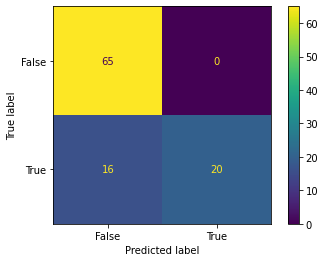

In [10]:
confusion_matrix = metrics.confusion_matrix(y_actual_without_background, y_predicted_without_background)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

### 5.) Displaying the results in the label images

In [11]:
#create list with number of objects in label_image
number_elements = []
for label in label_list:
    in_label = np.unique(label)
    number_elements.append(max(in_label))

In [12]:
def make_slices(list_of_sizes):
    '''Make a list of slice objects from a list of sizes'''
    # sizes = [len(n) for n in list_of_objects] 
    slice_list = []
    for i, n in enumerate(list_of_sizes):
        if i==0:
            n_1 = 0
            slc = slice(n)
        else:        
            slc = slice(n_1, n_1 + n)
        n_1 += n
        slice_list += [slc]
    return slice_list

In [28]:
slice_list = make_slices(number_elements)

In [14]:
annotation_per_image_list =[]
prediction_per_image_list = []

for slc in slice_list:
    # get annotation for every single image
    annotation_per_image = table['annotated_class'][slc]
    annotation_per_image_list.append(annotation_per_image)
    
    # get prediction for every single image
    prediction_per_image = table['predicted_class'] [slc]
    prediction_per_image_list.append(prediction_per_image)

In [15]:
predicted_classes_with_background = []
prediction = []

for prediction in prediction_per_image_list:
    # add background to the prediction
    predicted_class_with_background = [0] + prediction.tolist()
    predicted_classes_with_background.append(predicted_class_with_background)

In [16]:
#colormap
my_colors = [
    [0,0,0,1],
    [1,0,1,1],
    [0,1,0,1]
]

In [17]:
colormap = LinearSegmentedColormap.from_list("green_magenta", my_colors)

img01_20220429_ET358_56hpf_1.tif


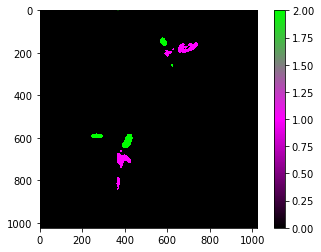

img02_20220429_ET358_56hpf_2.tif


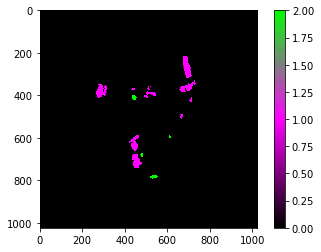

img03_20220429_ET358_56hpf_3.tif


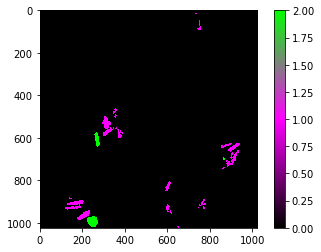

img05_20220513_ET358_56hpf_1.tif


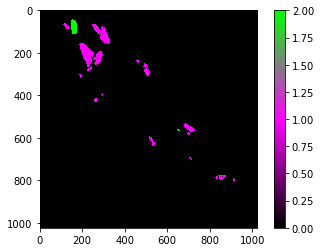

img06_20220513_ET358_56hpf_2.tif


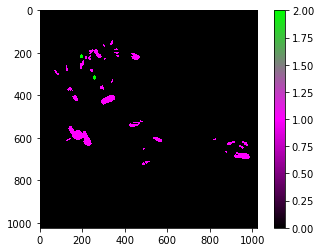

img08_20220513_ET358_56hpf_4.tif


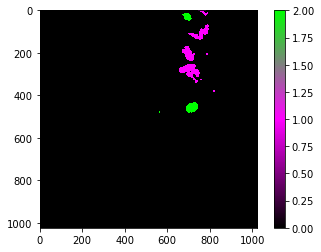

img10_20220513_ET358_56hpf_6.tif


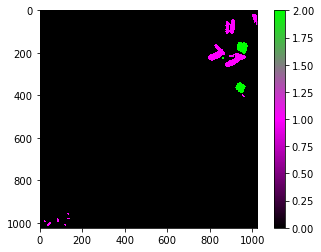

img12_20220513_ET358_56hpf_8.tif


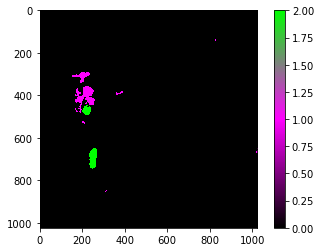

img13_20220513_ET358_56hpf_9.tif


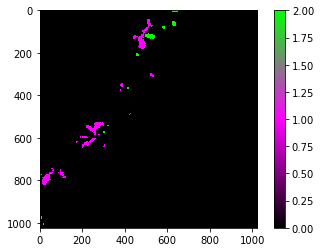

img14_20220520_hsp-mKate-DN-dynactin_56hpf_1.tif


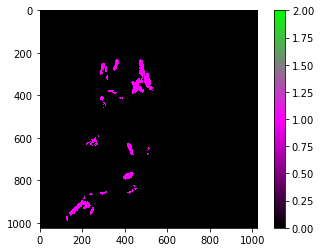

img15_20220520_hsp-mKate-DN-dynactin_56hpf_2.tif


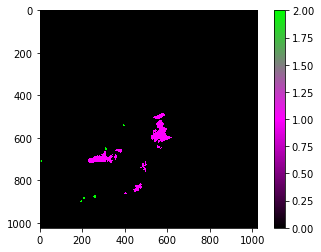

img17_20220520_hsp-mKate-DN-dynactin_56hpf_4.tif


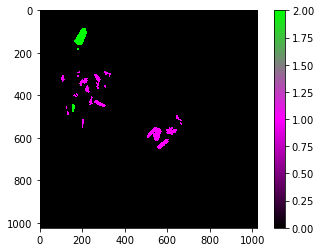

img18_20220520_hsp-mKate-DN-dynactin_56hpf_5.tif


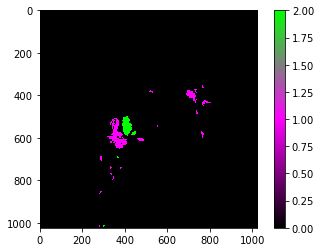

In [18]:
for label, prediction,filename in zip(label_list,predicted_classes_with_background,file_list):
    print(filename)
    
    # connect prediction to label image
    class_image = replace_intensities(label, prediction).astype(int)
    
    #show prediction
    imshow(class_image, colorbar= True,colormap=colormap,min_display_intensity=0, max_display_intensity = 2)

### 6.) Accuracy, Precision and Recall

In [19]:
all_annotated_classes_mask = all_annotated_classes > 0
comparison = {
    "ground_truth": all_annotated_classes[all_annotated_classes_mask],
    "predictions": predicted_classes[all_annotated_classes_mask]}
pd.DataFrame(comparison)

,ground_truth,predictions
0,2.0,2
1,1.0,1
2,2.0,2
3,2.0,2
4,1.0,1
...,...,...
96,1.0,1
97,2.0,1
98,1.0,1
99,1.0,1


In [21]:
#accuracy 
print('Accuracy: %.3f' % accuracy_score(y_actual[all_annotated_classes_mask], y_predicted[all_annotated_classes_mask]))
#In binary classification, this function is equal to the jaccard_score function

#precision
print('Precision: %.3f' % precision_score(y_actual[all_annotated_classes_mask], y_predicted[all_annotated_classes_mask]))

#recall
print('Recall: %.3f' % recall_score(y_actual[all_annotated_classes_mask], y_predicted[all_annotated_classes_mask]))

#F1-score
print('F1 Score: %.3f' % f1_score(y_actual[all_annotated_classes_mask], y_predicted[all_annotated_classes_mask]))

Accuracy: 0.842
Precision: 0.802
Recall: 1.000
F1 Score: 0.890


### 7.) Selecting only PL

In [22]:
good_crystals = table.loc[table['predicted_class'] == 2]
good_crystals

,Unnamed: 0,label,area,max_intensity,mean_intensity,min_intensity,solidity,extent,minor_axis_length,eccentricity,...,roundness_skimage,circularity,median,sum,variance,number_of_pixels_on_border,perimeter_on_border_ratio,filename,annotated_class,predicted_class
0,0,1,1031,6.700000,2.412512,0.000000,0.917260,0.728107,21.988822,0.931903,...,0.357171,0.589689,2.300977,2487.300000,1.715426,0,0.000000,img01_20220429_ET358_56hpf_1.tif,2.0,2
3,3,4,51,2.600000,1.239216,0.200000,0.980769,0.850000,6.114710,0.828159,...,0.545592,0.973584,1.225195,63.200000,0.309631,10,0.370292,img01_20220429_ET358_56hpf_1.tif,0.0,2
5,5,6,2241,11.800000,4.143418,0.000000,0.920329,0.612797,37.829129,0.870965,...,0.481362,0.667209,4.273242,9285.400000,5.129368,0,0.000000,img01_20220429_ET358_56hpf_1.tif,2.0,2
6,6,7,895,8.300000,3.069832,0.000000,0.965480,0.740281,27.867093,0.734805,...,0.675096,0.844586,2.898633,2747.500000,3.161997,0,0.000000,img01_20220429_ET358_56hpf_1.tif,2.0,2
8,8,9,122,4.200000,1.377869,0.200000,0.924242,0.782051,11.701397,0.499447,...,0.851483,0.932077,1.284961,168.100000,0.535126,0,0.000000,img01_20220429_ET358_56hpf_1.tif,0.0,2
14,14,4,438,9.000000,2.999239,0.000000,0.956332,0.732441,21.301247,0.589733,...,0.801613,0.900432,2.895833,1313.666667,3.306918,0,0.000000,img02_20220429_ET358_56hpf_2.tif,2.0,2
16,16,6,182,5.555556,1.932845,0.000000,0.923858,0.777778,11.978662,0.790555,...,0.605651,0.807686,1.770833,351.777778,1.519645,0,0.000000,img02_20220429_ET358_56hpf_2.tif,0.0,2
20,20,10,457,4.777778,1.734500,0.000000,0.923232,0.705247,15.931044,0.902210,...,0.426471,0.684470,1.562500,792.666667,1.029474,0,0.000000,img02_20220429_ET358_56hpf_2.tif,2.0,2
21,21,11,72,2.666667,1.149691,0.222222,0.960000,0.727273,8.336461,0.655774,...,0.751837,1.035716,1.020833,82.777778,0.386075,0,0.000000,img02_20220429_ET358_56hpf_2.tif,0.0,2
30,30,5,2097,5.638889,2.788627,0.361111,0.974895,0.791321,49.727864,0.404530,...,0.903025,0.875011,2.974447,5847.750000,1.058031,0,0.000000,img03_20220429_ET358_56hpf_3.tif,2.0,2


In [23]:
good_crystals.to_csv("Trainingdata_good_crystals.csv")

### 8.) Feature Importance

notebook reference: https://github.com/haesleinhuepf/apoc/blob/feature_importance/demo/table_row_classification.ipynb 

In [24]:
def colorize(styler):
        styler.background_gradient(axis=None, cmap="plasma")
        return styler

shares, counts = classifier.statistics()
df = pd.DataFrame(shares).T
df_beautiful = df.style.pipe(colorize)
display(df_beautiful)

,0,1
area,0.000000,0.136364
max_intensity,0.285714,0.272727
mean_intensity,0.071429,0.000000
min_intensity,0.000000,0.045455
solidity,0.142857,0.136364
extent,0.142857,0.090909
minor_axis_length,0.000000,0.000000
eccentricity,0.000000,0.000000
aspect_ratio,0.000000,0.045455
roundness_skimage,0.071429,0.090909


In [25]:
feature_importances = classifier.feature_importances()

In [26]:
df_feature_importances = pd.DataFrame(list(feature_importances.items()),columns = ['parameter','feature importance']) 

In [27]:
df_colorful_feature_importance = df_feature_importances.style.pipe(colorize)
display(df_colorful_feature_importance)

,parameter,feature importance
0,area,0.021103
1,max_intensity,0.056355
2,mean_intensity,0.055400
3,min_intensity,0.004911
4,solidity,0.223179
5,extent,0.197765
6,minor_axis_length,0.000000
7,eccentricity,0.000000
8,aspect_ratio,0.031151
9,roundness_skimage,0.111717
